In [37]:
__author__ = 'eribeiro'
#
import numpy as np               # Numpy library
from PIL import Image as im      # Basic image processing library 

In [38]:
class Ray:
    """A class representing a ray (line in space). 
    
    Uses the parametric representation of a line, p(t) = e + (s - e)*t.
    
    The ray passes through the following two points: 

    e = [e_u, e_v, e_w] representing the eye location in 3-D, and      
    s = [e_u, e_v, e_w] representing a point on the image plane.

    Attributes:
        e: 3x1 np.array, e.g., 
        s: 3x1 np.array 
    """

    def __init__(self, e, s):
        """Constructor method

        Args:
            e (3x1 np.array): Eye location
            s (3x1 np.array): Point on the image plane
        """
        self.e = e   
        self.s = s   


    def get3DPoint(self, t):        
        """Calculates the location of a 3-D point along the ray given t.

        Args:
            t (float): Parameter of the ray equation
        Returns:
            p (3x1 nd.array): Point p(t) = e + (s - e) * t.
        """
        p = self.e + (self.s - self.e) * t    # p(t) = e + (s - e) * t
        
        return p

In [39]:
class Sphere:
    """A class representing a Sphere.

    Attributes:
        Center (3x1 np.ndarray): Center of the sphere in 3-D
        Radius (float): Radius of the sphere
        Color (3x1 np.ndarray): (Solid) Color of the sphere's surface Color = [ red, green, blue]
    """
    
    def __init__(self, c, r, k):
        """Constructor method

        Args:
            c (3x1 np.ndarray): Center 
            r (float): Radius
            k (3x1 np.ndarray): Color [red, green, blue], each component is in the [0,255] range            
        """
        self.Center = c
        self.Radius = r
        self.Color = k

    def Intersect(self, ray):
        """Calculates the intersection of this sphere and the ray provided as input

        Args:
            ray (Ray object)  p(t) = e + (s - e) * t
        Returns:
            t (float): distance (line parameter) from the eye to the intersection point along the ray
        """
        # ray: ray object  p(t) = e + (s - e) * t

        # For calculations, I prefer to use the notation
        # similar to the one in the slides or associated paper.
        d = ray.s - ray.e  # Direction of the ray
        e = ray.e          # Ray's starting point

        c = self.Center  # Sphere center
        r = self.Radius  # Sphere radius

        # Check whether the ray intersects the sphere
        A = np.dot(d, d)
        B = 2.0 * np.dot(d, (e - c))
        C = np.dot((e - c), (e - c)) - r * r

        #delta = B*B - A * C
        delta = B*B - 4.0 * A * C
        if delta < 0:
            return float("inf")         # Ray didn't intersect sphere
        else:
            # Compute value of parameter t at the intersection point
            t1 = (-B - np.sqrt(delta)) / (2.0 * A)
            t2 = (-B + np.sqrt(delta)) / (2.0 * A)

            # We are interested only in the closest intersection.
            # We take the smaller t
            t = np.min([t1, t2])
            
            return t
        
    def get_normal(self, p):
        """ Calculates the surface normal at the point p on the sphere. 
            It assumes that p is on the sphere!!!
        Args:
            p (3x1 np.ndarray): 3-D point on the sphere 
        Returns:
            n (3x1 np.ndarray): Normalized (unit) normal vector at point p
        """
        
        n = (p - self.Center) / np.linalg.norm(p - self.Center)
        
        return n

In [40]:
class Camera:
    """A class representing the camera.
    
    This camera consists of the focal length, the image matrix, and functions 
    that convert pixel coordinates to geometric (u,v,w)-coordinates. 

    Attributes:
        f (float): Camera's focal distance
        
        nrows (int): Image horizontal resolution in pixels 
        ncols (int): Image vertical resolution in pixels 
        I (np.ndarray of size nrows x ncols)
    """

    
    def __init__(self, f, nrows, ncols,nchannels):
        # f: Focal distance 
        self.f = f         
        self.nrows = nrows    # Image resolution in pixels 
        self.ncols = ncols
        self.eye = np.array((0.0, 0.0, 0.0)).transpose()
        self.nchannels = nchannels
        # Initialize image matrix 
        self.I = np.zeros([self.nrows, self.ncols, self.nchannels])

    'Ray-sphere intersection. It returns the smallest t. '
    def ij2uv(self, i, j):
        u =  (j + 0.5) - self.ncols/2 
        v = -(i + 0.5) + self.nrows/2
        
        return u,v

    def constructRayThroughPixel(self, i, j):
        # Construct ray through pixel (i,j)
        u,v = self.ij2uv(i, j)
        s = np.array((u, v, -self.f)).transpose()
        ray = Ray(self.eye, s)                        

        return ray

In [41]:
class HitInformation:
    """A class representing the all the information of objects intersected by a given ray.

    Attributes:
        Object (python class of object): e.g., sphere, cylinder, cone, plane
        
        p (3x1 np.ndarray): 3-D coordinates of the intersection point 
    """
    def __init__(self, intersected_object, intersecton_point):
        self.Object = intersected_object
        self.p = intersecton_point

In [42]:
class Plane:
    """A class representing a plane. 

    The components of the plane equation are: 
    
    - A point on the plane
    - The planes normal vector (i.e., a normalized vector perpendicular to the plane)
    - The color (flat/solid) of the plane (RGB)

    Attributes:
        p1 (3x1 np.ndarray): any point on the plane        
        n (3x1 np.ndarray): the normalized vector that perpendicular to the plane
        Color (3x1 np.ndarray): the plane's color
    """
    def __init__(self, p1, n, k):
        """Constructor method

        Args:
            p1 (3x1 np.ndarray): Point on the plane 
            n (3x1 np.ndarray): Plane's normal vector
            k (3x1 np.ndarray): Color [red, green, blue], each component is in the [0,255] range            
        """
        self.p1    = p1
        self.n     = n / np.linalg.norm(n) 
        self.Color = k
    def get_normal(self, p):
        return self.n
    
    def Intersect(self, ray):
        """Calculates the intersection of this plane and the ray provided as input

        Args:
            ray (Ray object)  p(t) = e + (s - e) * t
        Returns:
            t (float): distance (line parameter) from the eye to the intersection point along the ray
        """
        d = ray.s - ray.e
        e = ray.e
        t = np.dot(self.p1 -e, self.n)/np.dot(d,self.n)
        if t < 0:
            return float ("inf")
        return t
   

In [43]:
class Scene: 
    """A class representing the whole scene, i.e., objects in the scene.

    I wanted Scene to consist of the entire scene that consists of 
    all objects (e.g., spheres, planes, triangles, cilinders). 
    
    Here is just a preliminary attempt of implementing a list of objects.         

    Attributes:
        Object (python class of object): e.g., sphere, cylinder, cone, plane
        
        p (3x1 np.ndarray): 3-D coordinates of the intersection point 
    """
    
    light_source_1 = np.array([0,0,1])
    light_source_1 = light_source_1 / np.linalg.norm(light_source_1)
    
    
    def __init__(self, theCamera):
        
        self.theCamera = theCamera   # I think I need the camera because it has the eye location 
        
        # I simply implement this class as a list of geometrical objects. 
        list = []
        
        # Object 1
        Center = np.array((-120, 0, -400.0)).transpose()
        Radius = 80.0
        Color = np.array((255, 0, 0)).transpose()        
        list.append(Sphere(Center, Radius, Color))
        
        # Object 2
        Center = np.array((50, 0, -400.0)).transpose()
        Radius = 80.0
        Color = np.array((0, 255, 0)).transpose()                    
        list.append(Sphere(Center, Radius, Color))
        
        
        # Object 3 (the plane)
        p1 = np.array((0,40,-400)).transpose()
        n =np.array((np.sin(1/2),1,0)).transpose()
        k=np.array((0,0,0))
        list.append(Plane(p1, n,k))
        
        # List of objects in the scene 
        self.scene_objects = list
           
    def find_intersection(self, ray):
        """Intersects the ray with the scene (all objects in the scene)

        Args:
            ray (Ray object)  p(t) = e + (s - e) * t
        Returns:
            hit (python list): list with the information about the hits.
        """
        hit_list = []        # List of intersections (location and object intersected)
        for surface in self.scene_objects: 
            t = surface.Intersect(ray)                  # t parameter at intersection point
            if float('inf') != t:                       # Does the ray intersects the surface? 
                p = ray.get3DPoint(t)                   # (u,v,w) coordinates of intersection point
                hitInfo = HitInformation(surface, p)
                hit_list.append(hitInfo)                     # We might need more attributes...

        return hit_list     # List with the information about the hits

    def get_color(self, hit_list):  
        """Returns the `seen' by the visual ray. This is the sum of all colors * shading 
        """
        pixelColor =  np.array((0.0, 0.0, 0.0))  # Initial color is black               
        for hit in hit_list:                    # Loop through hits             
            
            # Get surface normal at the intersection point
            n = hit.Object.get_normal(hit.p)
            # Calculate diffuse shading 
            diffuse_shading = max(0, np.dot(self.light_source_1, n))
            
            # Ambient light component
            ambient_color = hit.Object.Color * 0.3 
            
            # Calculate specular component 
            v = self.theCamera.eye - hit.p
            h = v + self.light_source_1
            h = h / np.linalg.norm(h)
            
            specular_component = max(0, np.dot(n, h)) ** 47


            pixelColor += ambient_color + hit.Object.Color * diffuse_shading  + hit.Object.Color * specular_component# Color of the intersected object (at the intersection point)  
         
            # Each color component is in the range [0..255]. 
            pixelColor =  pixelColor / len(self.scene_objects)
            
            #np.linalg.norm(pixelColor)
            
        
        return pixelColor

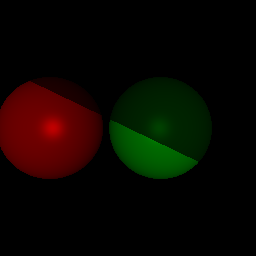

In [44]:
# Create camera (and image resolution)
nrows = 256
ncols = 256
nchannels = 3
# Focal distance
f = 250.0

myCamera = Camera(f, nrows, ncols,nchannels)

# Create the scene (collection of objects - hardcoded for simplicity)
theScene = Scene(myCamera)

# Loop through all pixels (i,j) in the image matrix 
for i in range(nrows): 
    for j in range(ncols):
        # Construct the ray between between the eye and s = (u, v, -f)       
        ray = myCamera.constructRayThroughPixel(i, j)
        
        # Intersect the ray with the scene (all objects in the scene)
        hit = theScene.find_intersection(ray)   
                                                
        # Set the pixel color 
        myCamera.I[i,j,:] = theScene.get_color(hit)
       
        
# Create an image from an array (display image and save file)
out_image = im.fromarray(np.uint8(myCamera.I))
display(out_image)
out_image.save('raytraced_scene.png')

In [45]:
#I found another example of ray tracing and based my work progress on this
#this was the link for the page https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9



import numpy as np
import matplotlib.pyplot as plt

def normalize(vector):
    return vector / np.linalg.norm(vector)

def reflected(vector, axis):
    return vector - 2 * np.dot(vector, axis) * axis

def sphere_intersect(center, radius, ray_origin, ray_direction):
    b = 2 * np.dot(ray_direction, ray_origin - center)
    c = np.linalg.norm(ray_origin - center) ** 2 - radius ** 2
    delta = b ** 2 - 4 * c
    if delta > 0:
        t1 = (-b + np.sqrt(delta)) / 2
        t2 = (-b - np.sqrt(delta)) / 2
        if t1 > 0 and t2 > 0:
            return min(t1, t2)
    return None

def nearest_intersected_object(objects, ray_origin, ray_direction):
    distances = [sphere_intersect(obj['center'], obj['radius'], ray_origin, ray_direction) for obj in objects]
    nearest_object = None
    min_distance = np.inf
    for index, distance in enumerate(distances):
        if distance and distance < min_distance:
            min_distance = distance
            nearest_object = objects[index]
    return nearest_object, min_distance

width = 300
height = 200

max_depth = 3

camera = np.array([0, 0, 1])
ratio = float(width) / height
screen = (-1, 1 / ratio, 1, -1 / ratio) # left, top, right, bottom

light = { 'position': np.array([5, 5, 5]), 'ambient': np.array([1, 1, 1]), 'diffuse': np.array([1, 1, 1]), 'specular': np.array([1, 1, 1]) }

objects = [
    { 'center': np.array([-0.2, 0, -1]), 'radius': 0.7, 'ambient': np.array([0.1, 0, 0]), 'diffuse': np.array([0.7, 0, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 },
    { 'center': np.array([0.1, -0.3, 0]), 'radius': 0.1, 'ambient': np.array([0.1, 0, 0.1]), 'diffuse': np.array([0.7, 0, 0.7]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 },
    { 'center': np.array([-0.3, 0, 0]), 'radius': 0.15, 'ambient': np.array([0, 0.1, 0]), 'diffuse': np.array([0, 0.6, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 },
    { 'center': np.array([0, -9000, 0]), 'radius': 9000 - 0.7, 'ambient': np.array([0.1, 0.1, 0.1]), 'diffuse': np.array([0.6, 0.6, 0.6]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5 }
]

image = np.zeros((height, width, 3))
for i, y in enumerate(np.linspace(screen[1], screen[3], height)):
    for j, x in enumerate(np.linspace(screen[0], screen[2], width)):
        # screen is on origin
        pixel = np.array([x, y, 0])
        origin = camera
        direction = normalize(pixel - origin)

        color = np.zeros((3))
        reflection = 1

        for k in range(max_depth):
            # check for intersections
            nearest_object, min_distance = nearest_intersected_object(objects, origin, direction)
            if nearest_object is None:
                break

            intersection = origin + min_distance * direction
            normal_to_surface = normalize(intersection - nearest_object['center'])
            shifted_point = intersection + 1e-5 * normal_to_surface
            intersection_to_light = normalize(light['position'] - shifted_point)

            _, min_distance = nearest_intersected_object(objects, shifted_point, intersection_to_light)
            intersection_to_light_distance = np.linalg.norm(light['position'] - intersection)
            is_shadowed = min_distance < intersection_to_light_distance

            if is_shadowed:
                break

            illumination = np.zeros((3))

            # ambiant
            illumination += nearest_object['ambient'] * light['ambient']

            # diffuse
            illumination += nearest_object['diffuse'] * light['diffuse'] * np.dot(intersection_to_light, normal_to_surface)

            # specular
            intersection_to_camera = normalize(camera - intersection)
            H = normalize(intersection_to_light + intersection_to_camera)
            illumination += nearest_object['specular'] * light['specular'] * np.dot(normal_to_surface, H) ** (nearest_object['shininess'] / 4)

            # reflection
            color += reflection * illumination
            reflection *= nearest_object['reflection']

            origin = shifted_point
            direction = reflected(direction, normal_to_surface)

        image[i, j] = np.clip(color, 0, 1)
    print("%d/%d" % (i + 1, height))

plt.imsave('image.png', image)

1/200
2/200
3/200
4/200
5/200
6/200
7/200
8/200
9/200
10/200
11/200
12/200
13/200
14/200
15/200
16/200
17/200
18/200
19/200
20/200
21/200
22/200
23/200
24/200
25/200
26/200
27/200
28/200
29/200
30/200
31/200
32/200
33/200
34/200
35/200
36/200
37/200
38/200
39/200
40/200
41/200
42/200
43/200
44/200
45/200
46/200
47/200
48/200
49/200
50/200
51/200
52/200
53/200
54/200
55/200
56/200
57/200
58/200
59/200
60/200
61/200
62/200
63/200
64/200
65/200
66/200
67/200
68/200
69/200
70/200
71/200
72/200
73/200
74/200
75/200
76/200
77/200
78/200
79/200
80/200
81/200
82/200
83/200
84/200
85/200
86/200
87/200
88/200
89/200
90/200
91/200
92/200
93/200
94/200
95/200
96/200
97/200
98/200
99/200
100/200
101/200
102/200
103/200
104/200
105/200
106/200
107/200
108/200
109/200
110/200
111/200
112/200
113/200
114/200
115/200
116/200
117/200
118/200
119/200
120/200
121/200
122/200
123/200
124/200
125/200
126/200
127/200
128/200
129/200
130/200
131/200
132/200
133/200
134/200
135/200
136/200
137/200
138/200
139/